# TP2 - Vision Transformers - CEIA

Alumno: Isidro Marco Joel (a1520)

## Tareas:

1. **Implementar la arquitectura de un Vision Transformer** 

2. **Ingresar y ajustar los parametros del modelo**

3. **Probar diferentes técnicas de data augmentation** 

## Resolución



### Definiciones e importaciones generales

A continuación se realizan todas las definiciones e importaciones necesarias para la realización del trabajo.

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer

In [2]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

Dispositivo:  cuda
Torch version:  2.5.0+cu124


In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        # se inicializan como parámetros
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # se suman los embeddings a los parches
        return x + self.pos_embedding

In [11]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

# Function to denormalize and visualize the images
def imshow(img, labels):
    # Denormalize
    img = img / 2 + 0.5  # Inverse of normalization
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Rearranging dimensions for plt.imshow
    plt.title("Labels: " + ", ".join([str(label.item()) for label in labels]))
    plt.axis('off')  # Turn off axis
    plt.show()
    
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1, batch_first=True):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False,batch_first=batch_first)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        return self.transformer_encoder(x)

### Implementar la arquitectura de un Vision Transformer 

| Modelo    | Layers | D | MLP | Heads | Params |
|-----------|-------|--------------------|------------|-------------------|----------------------|
| ViT-Base  | 12    | 768                | 3072       | 12               | 86M                 |
| ViT-Large | 24    | 1024               | 4096       | 16               | 307M                |
| ViT-Huge  | 32    | 1280               | 5120       | 16               | 632M                |

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self, 
                 img_size: int, 
                 patch_size: int, 
                 embed_dim: int, 
                 num_heads: int, 
                 ff_dim: int, 
                 num_layers: int, 
                 dropout: float = 0.1, 
                 num_classes: int = 10,
                 batch_first: bool = True):
        
        super(VisionTransformer, self).__init__()
        
        self.patch_embedding = PatchEmbedding(img_size=img_size, patch_size=patch_size, embed_dim=embed_dim)
        num_patches = (img_size // patch_size) ** 2
        self.positional_encoding = PositionalEncodingLearned(num_patches=num_patches, embed_dim=embed_dim)
        
        self.transformer_encoder = TransformerEncoder(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, num_layers=num_layers, dropout=dropout, batch_first=batch_first)
        self.linear = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embedding(x)  # (B, num_patches, embed_dim)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        output = self.linear(x[:, 0])
        return output

### Entrenamientos

A continuación se realizan multiples entrenamientos  con diferentes técnicas de data augmetnation.

#### Train 1

Luego de varios entrenameintos se llego a la conclusión que debido a la resolución de las imágenes se debía de plantear un modelo con menos parámetros. Por ende se utilizaron los siguientes parámetros:


In [7]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,         # Tamaño de la imagen de entrada
    patch_size=4,        # Tamaño del parche
    embed_dim=256,        # Dimensión de embedding de cada parche
    num_heads=4,         # Número de cabezas de atención
    ff_dim=512,          # Dimensión del feed-forward
    num_layers=6,        # Número de capas en el encoder
    num_classes=10,     # Número de clases para clasificación
    dropout=0.1,           # Tasa de dropout
    batch_first=True
).to(device)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0559, -0.1101, -0.1379, -0.1343],
          [ 0.0786, -0.0107, -0.0078, -0.0625],
          [-0.1277, -0.0921, -0.0342,  0.0146],
          [ 0.1126,  0.0304,  0.1357,  0.0883]],

         [[ 0.1117,  0.0669, -0.0751, -0.0377],
          [-0.1136,  0.0936,  0.1012, -0.0535],
          [-0.0287, -0.1082,  0.0200,  0.0895],
          [ 0.1274,  0.0286,  0.1258,  0.0194]],

         [[ 0.1387, -0.1395,  0.0761, -0.0696],
          [ 0.1131, -0.0083,  0.0799, -0.0413],
          [ 0.0367, -0.0804,  0.0470,  0.0482],
          [ 0.1223,  0.0780, -0.0722, -0.0218]]],


        [[[ 0.0516,  0.1002,  0.0796,  0.0517],
          [ 0.1075, -0.0310, -0.1343,  0.0426],
          [ 0.0909,  0.0480,  0.0546, -0.1415],
          [-0.0987, -0.0227, -0.0823, -0.0652]],

         [[-0.0575, -0.0895,  0.1017,  0.1239],
          [ 0.1000,  0.0989,  0.0820,  0.1238],
          [-0.1259, -0.1067, -0.0452,  0.0479],
          [ 0.0963, -0.1074,  0.

In [8]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 3.18 millones


In [9]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3596713..1.2280922].


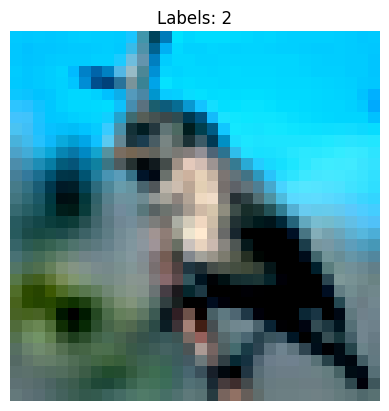

In [10]:
# Get a single batch of images and labels
images, labels = next(iter(train_loader))

# Visualize the first image in the batch
imshow(images[0], labels[0:1])  # Display only the first image and its label

In [12]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

class_names = train_dataset.classes

  0%|          | 0/20 [00:00<?, ?it/s]/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████| 20/20 [00:09<00:00,  2.15it/s]

Accuracy: 0.53
Precision: 0.52
Recall: 0.53
F1 score: 0.52


  0%|          | 0/20 [00:00<?, ?it/s]


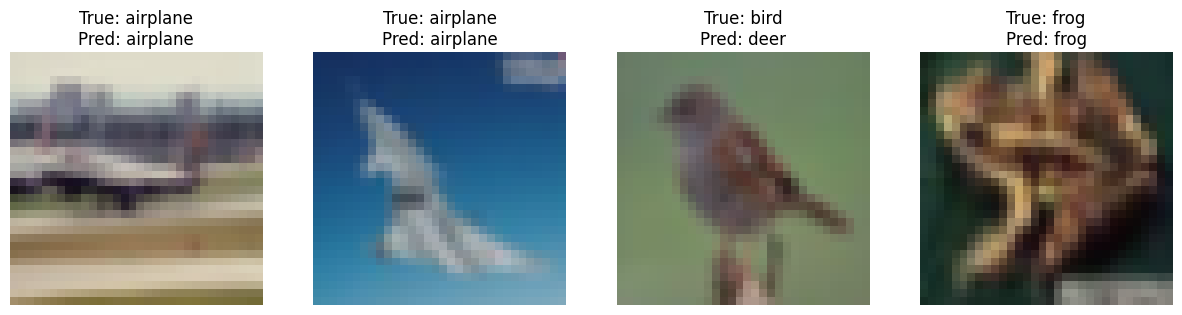

In [13]:
visualize_classification(model, test_loader, class_names, num_images=4)
plt.show()

#### Train 2

In [18]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,         # Tamaño de la imagen de entrada
    patch_size=4,        # Tamaño del parche
    embed_dim=256,        # Dimensión de embedding de cada parche
    num_heads=4,         # Número de cabezas de atención
    ff_dim=512,          # Dimensión del feed-forward
    num_layers=6,        # Número de capas en el encoder
    num_classes=10,     # Número de clases para clasificación
    dropout=0.1,           # Tasa de dropout
    batch_first=True
).to(device)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0848, -0.0478,  0.0668,  0.0101],
          [-0.0903, -0.0268,  0.1206,  0.0455],
          [-0.0172,  0.0279,  0.0953,  0.1082],
          [-0.0359, -0.0535, -0.1079,  0.0106]],

         [[-0.1181,  0.1333,  0.0238,  0.0747],
          [-0.1420, -0.0784,  0.0309, -0.0903],
          [ 0.1120,  0.1215, -0.0154,  0.1191],
          [-0.0394,  0.1310, -0.0251, -0.0455]],

         [[-0.0185, -0.0052,  0.0769,  0.0856],
          [-0.0350, -0.0487,  0.1089,  0.0945],
          [ 0.1047,  0.1351, -0.0063, -0.0361],
          [ 0.0978, -0.0826, -0.0820,  0.1374]]],


        [[[ 0.1383, -0.1123, -0.0456, -0.0922],
          [-0.1145, -0.0072,  0.0602,  0.0964],
          [-0.0225,  0.0815,  0.0844, -0.0344],
          [ 0.1141, -0.0280, -0.1247,  0.0150]],

         [[-0.0712, -0.1057,  0.1420, -0.1405],
          [-0.1253, -0.1009,  0.0816,  0.0141],
          [ 0.0464,  0.1064,  0.0369, -0.1064],
          [ 0.0196, -0.0668, -0.

In [19]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

class_names = train_dataset.classes

100%|██████████| 20/20 [00:07<00:00,  2.66it/s]

Accuracy: 0.46
Precision: 0.45
Recall: 0.46
F1 score: 0.45


  0%|          | 0/20 [00:00<?, ?it/s]


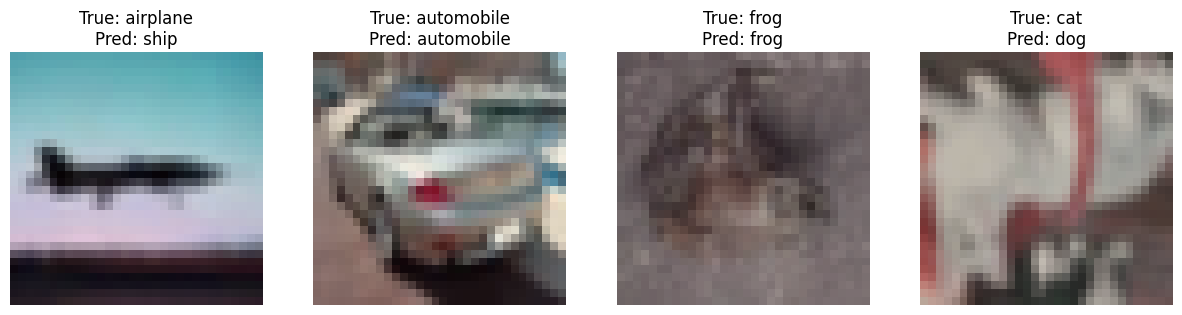

In [21]:
visualize_classification(model, test_loader, class_names, num_images=4)
plt.show()

#### Train 3

In [58]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,         # Tamaño de la imagen de entrada
    patch_size=4,        # Tamaño del parche
    embed_dim=256,        # Dimensión de embedding de cada parche
    num_heads=4,         # Número de cabezas de atención
    ff_dim=512,          # Dimensión del feed-forward
    num_layers=6,        # Número de capas en el encoder
    num_classes=10,     # Número de clases para clasificación
    dropout=0.1,           # Tasa de dropout
    batch_first=True
).to(device)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.1172,  0.0170, -0.0971,  0.0722],
          [-0.0605,  0.1335,  0.1180,  0.0137],
          [-0.0785, -0.0387,  0.0369,  0.1348],
          [ 0.0690, -0.0890, -0.0798, -0.1278]],

         [[-0.1120,  0.0472,  0.0118, -0.0852],
          [ 0.0208,  0.0697, -0.0828,  0.1040],
          [-0.0822, -0.0539, -0.0427, -0.1393],
          [-0.0786, -0.0413,  0.0610, -0.0795]],

         [[ 0.0495,  0.0335,  0.1281, -0.1390],
          [ 0.0842, -0.0512,  0.0519, -0.0057],
          [ 0.0331,  0.0250,  0.0575, -0.1125],
          [-0.0548, -0.0910,  0.0980, -0.0644]]],


        [[[ 0.0400, -0.1087, -0.1145, -0.0920],
          [ 0.0457, -0.1084,  0.0075,  0.0612],
          [ 0.0300, -0.1157,  0.0839, -0.0555],
          [-0.0894,  0.0062,  0.0565, -0.0558]],

         [[ 0.0278,  0.0505,  0.0382, -0.0261],
          [ 0.0904,  0.1271,  0.0742, -0.0285],
          [ 0.0320,  0.1234,  0.1294,  0.1441],
          [ 0.0755,  0.0557,  0.

In [59]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [60]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

class_names = train_dataset.classes

100%|██████████| 20/20 [00:05<00:00,  3.92it/s]

Accuracy: 0.46
Precision: 0.46
Recall: 0.46
F1 score: 0.46


  0%|          | 0/20 [00:00<?, ?it/s]


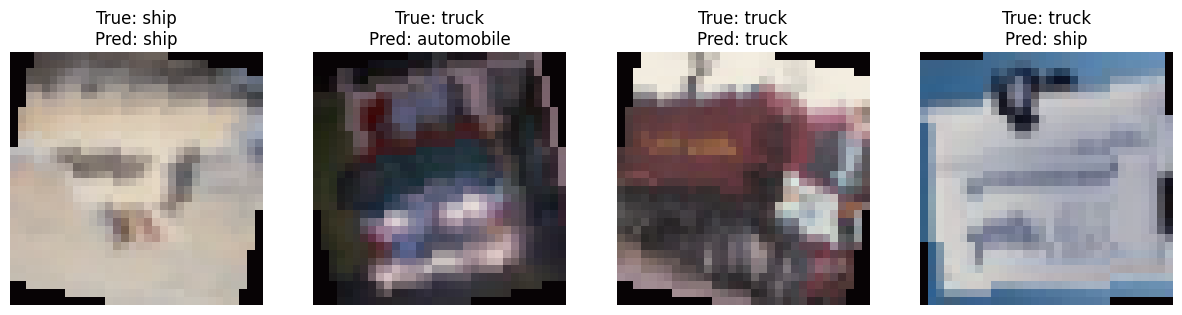

In [61]:
visualize_classification(model, test_loader, class_names, num_images=4)
plt.show()

#### Train 4

In [36]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,         # Tamaño de la imagen de entrada
    patch_size=4,        # Tamaño del parche
    embed_dim=256,        # Dimensión de embedding de cada parche
    num_heads=4,         # Número de cabezas de atención
    ff_dim=512,          # Dimensión del feed-forward
    num_layers=6,        # Número de capas en el encoder
    num_classes=10,     # Número de clases para clasificación
    dropout=0.1,           # Tasa de dropout
    batch_first=True
).to(device)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0140, -0.1068,  0.0823, -0.0190],
          [ 0.0749,  0.0087,  0.0508,  0.0921],
          [ 0.0180, -0.0124,  0.1085,  0.0801],
          [ 0.0436, -0.1040, -0.0713,  0.1217]],

         [[-0.1407,  0.0224, -0.0024, -0.0272],
          [ 0.0535, -0.0125,  0.1405,  0.0437],
          [-0.1130,  0.1423,  0.0451, -0.1384],
          [-0.0058,  0.0620,  0.1145, -0.0280]],

         [[ 0.1192, -0.1151, -0.0034,  0.1251],
          [-0.0228, -0.1247,  0.0768, -0.0239],
          [ 0.1400, -0.0617,  0.1352, -0.0014],
          [-0.1325, -0.0199,  0.0431, -0.1276]]],


        [[[-0.0411, -0.0886, -0.0290,  0.0202],
          [ 0.0037,  0.1126,  0.0159,  0.0872],
          [ 0.0641, -0.0110,  0.0888, -0.1259],
          [-0.0876, -0.0988, -0.1078, -0.0469]],

         [[-0.1015, -0.0238,  0.1124,  0.0817],
          [ 0.0868,  0.1259,  0.0360, -0.1192],
          [-0.1126, -0.0539, -0.0276, -0.1410],
          [-0.1344,  0.0119, -0.

In [37]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

class_names = train_dataset.classes

100%|██████████| 20/20 [00:05<00:00,  3.77it/s]

Accuracy: 0.49
Precision: 0.48
Recall: 0.49
F1 score: 0.48


  0%|          | 0/20 [00:00<?, ?it/s]


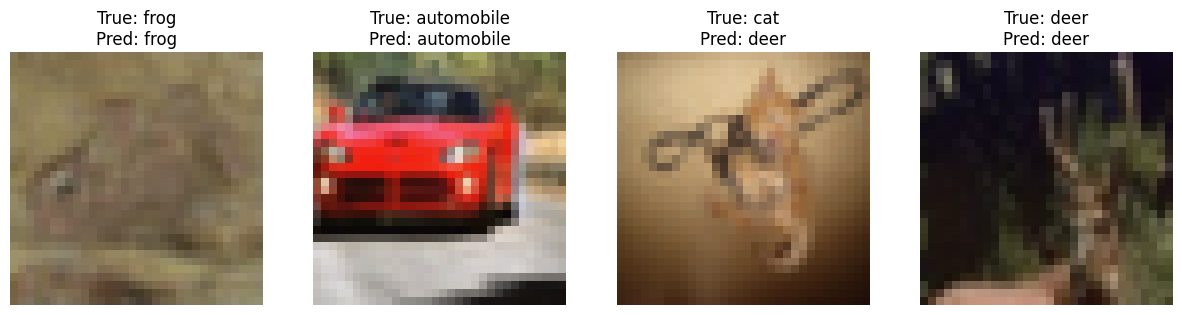

In [39]:
visualize_classification(model, test_loader, class_names, num_images=4)
plt.show()

#### Train 5

In [51]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,         # Tamaño de la imagen de entrada
    patch_size=4,        # Tamaño del parche
    embed_dim=256,        # Dimensión de embedding de cada parche
    num_heads=4,         # Número de cabezas de atención
    ff_dim=512,          # Dimensión del feed-forward
    num_layers=6,        # Número de capas en el encoder
    num_classes=10,     # Número de clases para clasificación
    dropout=0.1,           # Tasa de dropout
    batch_first=True
).to(device)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[-0.0010,  0.1207, -0.0742,  0.0684],
          [ 0.0142,  0.1432, -0.1363, -0.1389],
          [-0.0780, -0.0707, -0.1184,  0.0439],
          [ 0.1197,  0.0702,  0.1390, -0.1117]],

         [[ 0.0414,  0.1186,  0.1268, -0.0354],
          [-0.0887, -0.1368, -0.1149, -0.1028],
          [ 0.1186, -0.0835, -0.0192,  0.0913],
          [-0.0702, -0.0727,  0.1394,  0.1335]],

         [[ 0.0215, -0.0297, -0.0649, -0.0497],
          [-0.0058,  0.1374,  0.0772, -0.1297],
          [ 0.1139, -0.1215,  0.0558, -0.0755],
          [ 0.0103,  0.1216,  0.0967, -0.1131]]],


        [[[ 0.0833,  0.1256, -0.0524,  0.1349],
          [-0.1421,  0.0144,  0.0527,  0.1077],
          [ 0.0163, -0.0446, -0.1032,  0.0127],
          [-0.0324,  0.0898,  0.0374, -0.0159]],

         [[ 0.0205,  0.0689, -0.0656,  0.0797],
          [-0.1331,  0.0194, -0.0523,  0.0650],
          [-0.0034,  0.0839,  0.0854, -0.1351],
          [-0.1118, -0.1167, -0.

In [52]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

class_names = train_dataset.classes

100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Accuracy: 0.52
Precision: 0.51
Recall: 0.52
F1 score: 0.51


  0%|          | 0/20 [00:00<?, ?it/s]


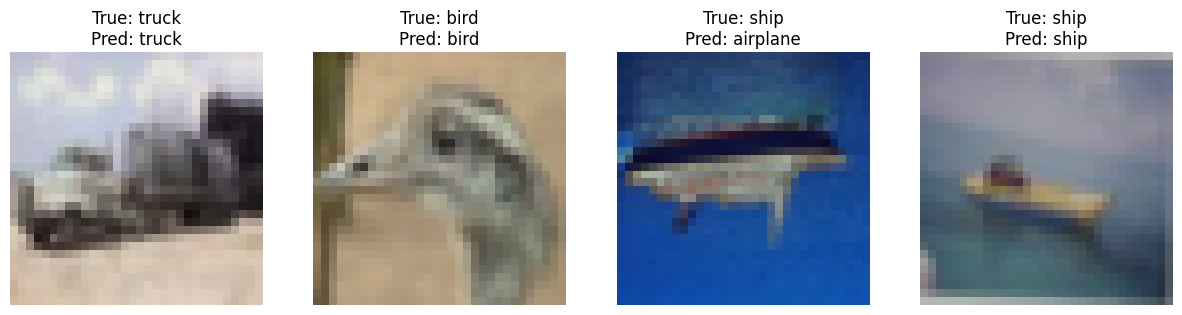

In [46]:
visualize_classification(model, test_loader, class_names, num_images=4)
plt.show()

#### Train 6

In [54]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,         # Tamaño de la imagen de entrada
    patch_size=4,        # Tamaño del parche
    embed_dim=512,        # Dimensión de embedding de cada parche
    num_heads=8,         # Número de cabezas de atención
    ff_dim=1024,          # Dimensión del feed-forward
    num_layers=6,        # Número de capas en el encoder
    num_classes=10,     # Número de clases para clasificación
    dropout=0.3,           # Tasa de dropout
    batch_first=True
).to(device)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/home/isidro-marco/.cache/pypoetry/virtualenvs/tps-ceia-vit-bhyr8ZO9-py3.10/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[-0.1035,  0.1116,  0.0852,  0.1157],
          [ 0.0611, -0.1420,  0.0149,  0.1236],
          [ 0.1336, -0.0401, -0.0561, -0.1276],
          [-0.0695,  0.0606,  0.0298, -0.1382]],

         [[ 0.0483,  0.0041, -0.1391,  0.1115],
          [ 0.0460, -0.0417, -0.0442, -0.0670],
          [-0.0397, -0.0297,  0.0797,  0.0786],
          [ 0.0517, -0.0699, -0.1335,  0.0041]],

         [[ 0.1161,  0.0270, -0.0202,  0.0356],
          [-0.0327,  0.1376, -0.0087, -0.1269],
          [ 0.0350, -0.1237,  0.0484,  0.0749],
          [ 0.1149, -0.0211, -0.0754, -0.1315]]],


        [[[ 0.0072, -0.0565,  0.0630,  0.1405],
          [ 0.0426, -0.0979,  0.1347, -0.0566],
          [ 0.0852, -0.0419,  0.0080,  0.0364],
          [-0.0540, -0.1303,  0.1032,  0.0830]],

         [[-0.0121, -0.0540, -0.1277,  0.0132],
          [-0.0973,  0.1244,  0.0175, -0.1125],
          [ 0.0559,  0.0286, -0.0794, -0.0576],
          [ 0.1218,  0.1137, -0.

In [55]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [56]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

class_names = train_dataset.classes

100%|██████████| 20/20 [00:09<00:00,  2.18it/s]

Accuracy: 0.53
Precision: 0.52
Recall: 0.53
F1 score: 0.52


  0%|          | 0/20 [00:00<?, ?it/s]


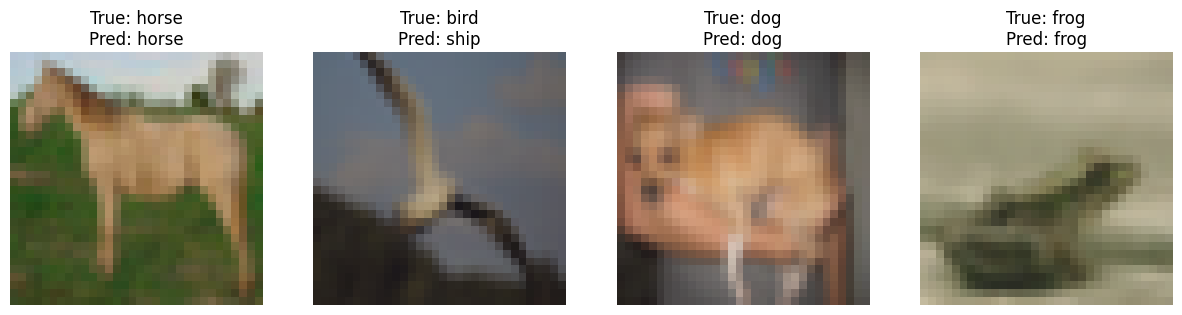

In [57]:
visualize_classification(model, test_loader, class_names, num_images=4)
plt.show()

### Conclusiones

#### Análisis y Conclusiones

1. **Transformaciones y Aumento de Datos**:
   - Aumentar las transformaciones no siempre mejoró el rendimiento; por ejemplo, `Train2` (que incluyó varias transformaciones) tuvo el peor rendimiento de todas las configuraciones. Esto sugiere que algunas transformaciones pueden introducir ruido excesivo o variabilidad que el modelo no puede aprender eficazmente. 
   - En base a las pruebas, se puede notar que la técnica que más empeoro el entrenamiento fue Vertical Flip, ya que al no considerarla el modelo conseguido mejoro. Esto se puede deber que al trabajar con resoluciones tan bajas, al aplicar transformaciones que pueden hacer que los objetos se observen de una forma imposible (un cabajo dado vuelta por ejemplo) le termina resultando imposible al modelo aprender a diferenciar las clases.

2. **Dimensiones y Parámetros del Modelo**:
   - Aumentar el tamaño del embedding (`embed_dim` de 256 a 512), el número de cabezas (`num_heads` de 4 a 8) y la dimensión del feed-forward (`ff_dim` de 512 a 1024) en `Train6` parece haber tenido un impacto positivo en el rendimiento, alcanzando valores similares a los mejores (`Accuracy` de 0.53). Sin embargo, esta mejora fue mínima lo que hace que el aumento de los mismos no sea recomendable.
   - Un aumento en la tasa de dropout (`dropout` de 0.1 a 0.3) ayudó en `Train6` a mitigar el sobreajuste, alcanzando una precisión ligeramente superior al reducir la dependencia excesiva de patrones específicos en los datos de entrenamiento.

3. **Efecto en las Métricas de Clasificación**:
   - Las métricas de precisión (Precision) y recuperación (Recall) se mantienen aproximadamente balanceadas en cada configuración, lo cual es favorable para la clasificación multiclase en un conjunto de datos como CIFAR-10. Esto indica que el modelo mantiene una consistencia en cuanto a la proporción de verdaderos positivos y verdaderos negativos para las clases.
   - Sin embargo, las métricas generales, como el `F1 Score`, se mantuvieron bajas en todos los experimentos, lo que sugiere que la capacidad de generalización podría mejorar con ajustes adicionales.
   - Para mejorar las métricas generales se podría trabajar con imágenes de mayor resolución, o dejar de usar solo el modelo más simple de ViTs para pasar a aplicar técnicas más avanzadas.

#### Resumen de entrenamientos

Con los siguientes parametros del modelo:

```
img_size=32
patch_size=4
num_layers=6
embed_dim=256
num_heads=4
ff_dim=512
dropout=0.1
```

Se entrenaron con las siguientes técnicas de aumento de datos, obtuviendo los resultados de la tabla.

| Entrenamiento | Transformaciones Aplicadas                                                          | Accuracy | Precision | Recall | F1 Score |
|---------------|-------------------------------------------------------------------------------------|----------|-----------|--------|----------|
| **Train1**    | Horizontal Flip, RandomResizedCrop, Normalize                                       | 0.53     | 0.52      | 0.53   | 0.52     |
| **Train2**    | Horizontal Flip, RandomResizedCrop, ColorJitter, Vertical Flip, Normalize           | 0.46     | 0.45      | 0.46   | 0.45     |
| **Train3**    | Horizontal Flip, RandomResizedCrop, RandomRotation, Vertical Flip, Normalize | 0.46     | 0.46      | 0.46   | 0.46     |
| **Train4**    | Horizontal Flip, ColorJitter (sin hue), Vertical Flip, Normalize                    | 0.49     | 0.48      | 0.49   | 0.48     |
| **Train5**    | Horizontal Flip, RandomResizedCrop, ColorJitter (sin hue), Normalize                | 0.52     | 0.51      | 0.52   | 0.51     |



Por otro lado, se obtuvieron los siguientes resultados modificando el número de parametros entrenables mediante las siguintes modificaciones:

```
embed_dim=512 
num_heads=8
ff_dim=1024
dropout=0.3
```

| Entrenamiento | Transformaciones Aplicadas                                                          | Accuracy | Precision | Recall | F1 Score |
|---------------|-------------------------------------------------------------------------------------|----------|-----------|--------|----------|
| **Train6**    | Horizontal Flip, ColorJitter (sin hue), RandomResizedCrop, Normalize                | 0.53     | 0.52      | 0.53   | 0.52     |